In [477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")

# 1.0 Read and Inspect the Data

This step contains the following:
  1. Reading the csv file
  2. Just inspecting the DF
  3. Checking it's shape
  4. Inspecting the different columns (in this case, no. of countries and the different metrics for the countries)
  5. Looking at the types of data in the columns
  6. Inspecting the statistics of each column to get a high-level idea of the spread of the different variables

In [478]:
findata = pd.read_csv('Country-data.csv')

In [479]:
findata.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [480]:
findata.shape

(167, 10)

In [481]:
findata.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [482]:
findata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [483]:
findata.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## 1.1 Observations

  * There is data for 167 countries
  * The dataset contains 10 columns, which includes 9 metrics the indicate the financial and health-conditions of every country
  * There are no nulls in any of the columns, as indicated when `info()` is run
  * The statistics indicate that there must be outliers in the dataset, given the huge variations in some of the parameters

Given the above statistics, it appears scaling would be necessary.

## 2.0 Data Cleaning/Preparation

- **`health`**, **`exports`** and **`imports`** are given as a percentage of GDP, per-capita (**`gdpp`**)
- So, convert them to actual values instead of percentages
    - Best way to do this is, just convert **`health`**, **`exports`** and **`imports`** into fractions and multiply them by **`gdpp`**

In [484]:
findata['exports'] = (findata['exports']/100)*findata['gdpp']
findata['health'] = (findata['health']/100)*findata['gdpp']
findata['imports'] = (findata['imports']/100)*findata['gdpp']

In [485]:
findata.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [486]:
findata.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [487]:
findata.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## 3.0 EDA

 - ###    3.1 Univariate Analysis

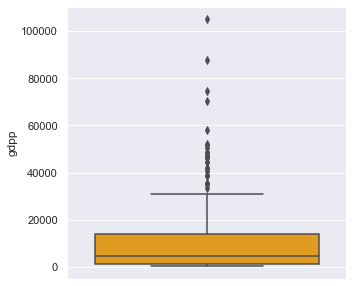

In [488]:
plt.figure(figsize = (5, 5))
sns.boxplot(findata.gdpp, orient = 'v', color='orange')
plt.show()

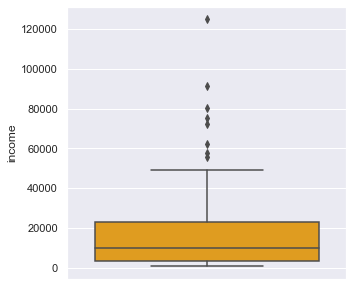

In [489]:
plt.figure(figsize = (5, 5))
sns.boxplot(findata.income, orient = 'v', color = 'orange')
plt.show()

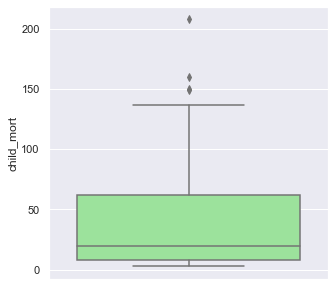

In [490]:
plt.figure(figsize = (5, 5))
sns.boxplot(findata.child_mort, orient = 'v', color = 'lightgreen')
plt.show()

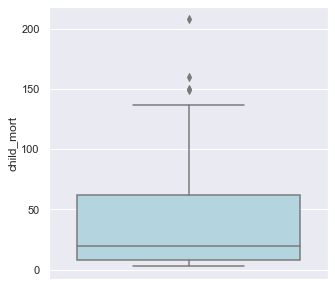

In [491]:
plt.figure(figsize = (5, 5))
sns.boxplot(findata.child_mort, orient = 'v', color = 'lightblue')
plt.show()

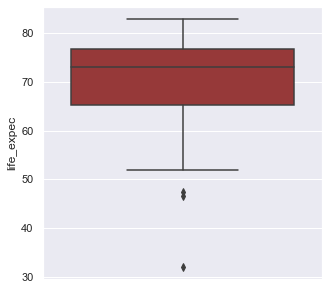

In [492]:
plt.figure(figsize = (5, 5))
sns.boxplot(findata.life_expec, orient = 'v', color = 'brown')
plt.show()

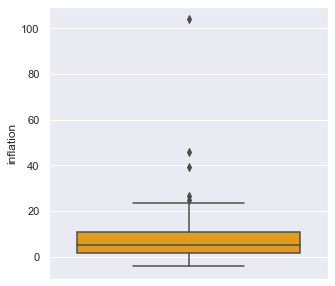

In [493]:
plt.figure(figsize = (5, 5))
sns.boxplot(findata.inflation, orient = 'v', color = 'orange')
plt.show()

- ### 3.2 Observations

   1. **`gdpp`** and **`income`** have too many outliers
   2. **`child_mort`** also has some outliers

- ### 3.3 Decisions
   - These need to be handled, since outliers affect clustering heavily
   - However, the idea is to **not** drop any rows, so that all data is used in clustering
   - Just cap the outliers
   - Again, since aid is to be given to countries in dire need, we do capping only at the top-end of **`gdpp`** and **`income`** and at the bottom-end of **`child_mort`**

In [494]:
findata.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [495]:
fin_data = findata.copy()
countries = fin_data.pop('country')

In [496]:
fin_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


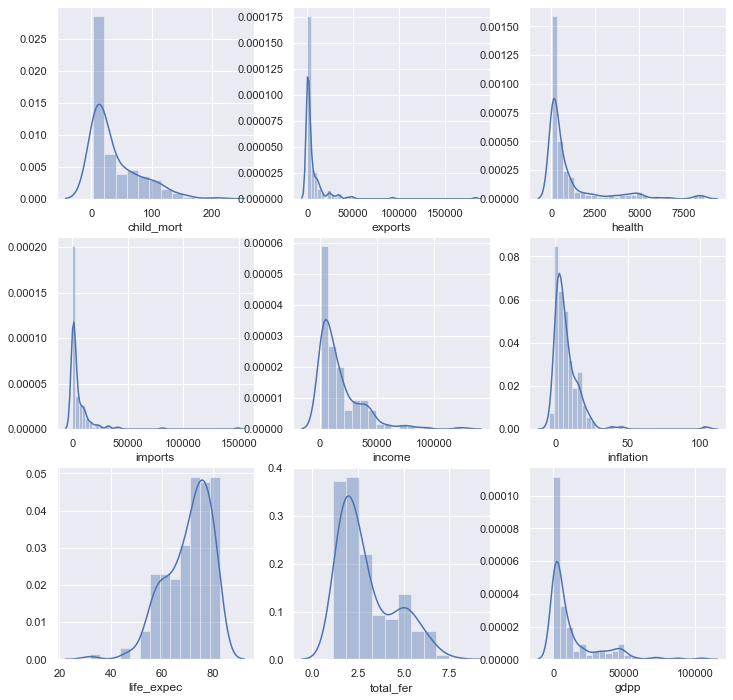

In [497]:
plt.figure(figsize = [12, 12])
for i in enumerate(fin_data):
    plt.subplot(3, 3, i[0] + 1)
    sns.distplot(fin_data[i[1]])
plt.show()

- ### 3.4 Observations
   - `exports` and `inflation` do not show a tendancy for clustering, since they appear to be continuously distributed
   - Most of the other columns do show a tendancy for clustering
   - We will consider all columns for clustering, but will do the clustering analysis on **`gdpp`**, **`income`** and **`child_mort`**
   - We can see that these 3 columns show a tendancy for clustering

- ### 3.5 Bivariate Analysis and Observations

   - Here, we try to plot a few representative columns against one-another

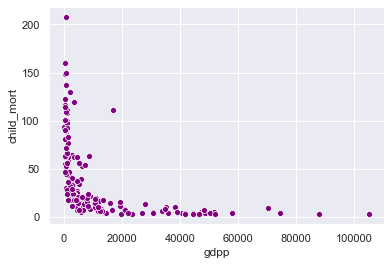

In [498]:
sns.scatterplot(x = 'gdpp', y = 'child_mort', data = fin_data, color = 'purple')
plt.show()

* We can see that, as gdpp increases, child mortality reduces drastically and vice-versa
* This means that the developed countries or countries with high gdpp, have better higiene and healthcare facilities to ensure low child-mortality

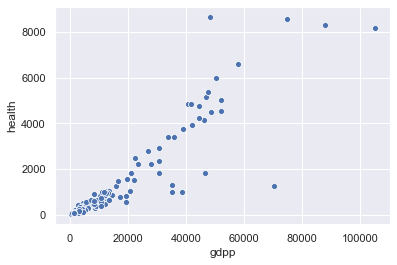

In [499]:
sns.scatterplot(x = 'gdpp', y = 'health', data = fin_data)
plt.show()

Here, we can observe that
 - As `gdpp` increases, healthcare expenditure or the amount stipulated for healthcare also increases
 - This actually means more money spent on health insurance and more budget allocation for healthcare
 - This is just an indication of the fact that richer nations (high `gdpp`) can afford to invest more in healthcare
 - It follows that these countires must have **low child mortality** and **high life expectancy**

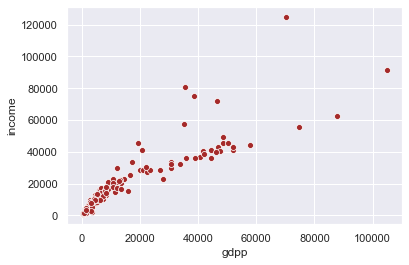

In [500]:
sns.scatterplot(x = 'gdpp', y = 'income', data = fin_data, color = 'brown')
plt.show()

 - We can see from the above plot that income increases almost linearly with gdpp (gdp per-capita), which is to be expected

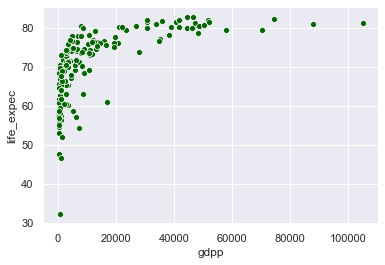

In [501]:
sns.scatterplot(x = 'gdpp', y = 'life_expec', data = fin_data, color = 'darkgreen')
plt.show()

  - From this plot, we can observe that life expectancy increases sharply with increase in `gdpp`
  - This is in line whatever was indicated in the healthcare plot. More gdpp implies more investment in healthcare and hence higher life-expectancy
  
  We now try to plot `gdpp` vs `health` with `life_expec` as the paramter variable

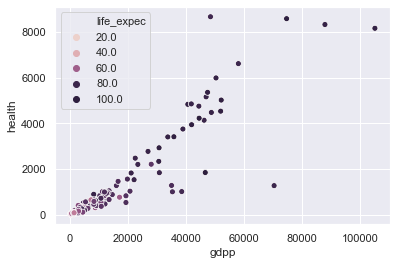

In [502]:
sns.scatterplot(x = 'gdpp', y = 'health', hue = 'life_expec', data = fin_data)
plt.show()

  - We can clearly see that life-expectancy increases with increase in `gdpp`, since higher gdpp implies higher alloation to healthcare

## 4.0 Outlier-capping

Outlier-capping has been done mainly keeping in mind that we have to identify countries that need aid. As a result:

   1. The following columns have been capped at either end (upper and lower), since they don't seem to have any specific relation to rich and poor countries
    - `exports`
    - `health`
    - `imports`
    - `total_fer`
   2. The following columns have been capped at the upper end, since higher values of these indicate that aid might not be required
    - `income`
    - `life_expec`
    - `gdpp`
    3. The following columns have been capped at the lower end, since very low value of these again indicate that aid might not be required
    - `child_mort`
    - `inflation`

In [503]:
# Child Mortality
q1 = fin_data.child_mort.quantile(0.01)
fin_data.child_mort[fin_data.child_mort <= q1] = q1

# exports
q1 = fin_data.exports.quantile(0.01)
q4 = fin_data.exports.quantile(0.99)
fin_data.exports[fin_data.exports <= q1] = q1
fin_data.exports[fin_data.exports >= q4] = q4


# health
q1 = fin_data.health.quantile(0.01)
q4 = fin_data.health.quantile(0.99)
fin_data.health[fin_data.health <= q1] = q1
fin_data.health[fin_data.health >= q4] = q4


# imports
q1 = fin_data.imports.quantile(0.01)
q4 = fin_data.imports.quantile(0.99)
fin_data.imports[fin_data.imports <= q1] = q1
fin_data.imports[fin_data.imports >= q4] = q4


# income
q4 = fin_data.income.quantile(0.99)
fin_data.income[fin_data.income >= q4] = q4

# inflation
q1 = fin_data.inflation.quantile(0.01)
fin_data.inflation[fin_data.inflation <= q1] = q1

# Life Expectancy
q4 = fin_data.life_expec.quantile(0.99)
fin_data.life_expec[fin_data.life_expec >= q4] = q4

# Total Fertility
q1 = fin_data.total_fer.quantile(0.01)
q4 = fin_data.total_fer.quantile(0.99)
fin_data.total_fer[fin_data.total_fer <= q1] = q1
fin_data.total_fer[fin_data.total_fer >= q4] = q4


# GDPP
q4 = fin_data.gdpp.quantile(0.99)
fin_data.gdpp[fin_data.gdpp >= q4] = q4

In [504]:
fin_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.271257,6538.351334,1054.240319,5873.845499,16857.550898,7.798194,70.551138,2.942896,12756.826347
std,40.327869,11415.230052,1790.825675,9422.259867,17957.012855,10.553699,8.886987,1.497595,17430.208938
min,2.800000,22.243716,17.009362,104.909640,609.000000,-2.348800,32.100000,1.243200,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,64794.260000,8410.330400,55371.390000,84374.000000,104.000000,82.370000,6.563600,79088.000000


We can observe the following from the current statistics of the different columns:

1. None of the rows have been deleted
2. `child_mort` has been capped at the lower end, the current min value being 2.8 as compared to 2.6 before
3. `gdpp` has been capped at the upper end, with the highest value now being 79088 as against 105000 before

Similarly, other columns have also been clamped correspondingly

In the below 2 figures, we do a boxplot of 

## 5.0 Hopkins' Score - 'clusterability'

- We nowe calculate the Hopkins' Score to check if the given dataset is amenable to clustering
- The Hopkins' score is calculated as below:
    - Generate a truly random uniformly distributed sample from 1 to n
    - Calculate the nearest neighbour distance for points from this sample and find the average. Let's call this **A**
    - Similarly, calculate the nearest neighbor distance for points form the actual dataset. Let's call this **B**
    - Now, if the actual dataset is also close to random, the nearest neighbor distance in the dataset will be close the that in the generated distribution
    - Hence, the Hopkins' score will be close to 0.5 or 50%
    - However, if the actual dataset has clusters, then its nearest neighbours distance sum will be lower
    - So, the Hopkins' score will go closer to 1, or 100%
    
- The following yardstick is used, as is the case in the industry:
      - hopkins_score < 60% - not good for clustering
      - 60% < hopkins_score < 80% - okay for clustering, but could be better
      - hopkins_score > 80% - very good for clustering
- Since Hopkins' Score is based on random data, this is calculated 20 times and the average is taken. This Average Hopkins' Score is checked to find out if the dataset is amenable to clustering

In [505]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [506]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins_score = []
for i in range(20):
    h_score = hopkins(fin_data)
    hopkins_score.append(h_score)

avg_hopkins_score = sum(hopkins_score)/len(hopkins_score)
print(round(avg_hopkins_score*100, 2))

92.17


- **We can see that the Average Hopkins' Score is 92.17%,  which indicates a very good clustering tendancy**
- So, we can go ahead with clustering this dataset

## 6.0 Scaling

- We now perform scaling to ensure that the data in different columns are within manageable ranges

In [507]:
fin_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0


In [508]:
scaler = StandardScaler()
num_cols = fin_data.columns
fin_data[num_cols] = scaler.fit_transform(fin_data[num_cols])
fin_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.569638,-0.566983,-0.598844,-0.851668,0.156035,-1.619705,1.926928,-0.702259
1,-0.538993,-0.473873,-0.440417,-0.413679,-0.386946,-0.314406,0.648831,-0.865911,-0.498726
2,-0.272870,-0.424015,-0.486295,-0.476198,-0.221053,0.788991,0.671403,-0.035427,-0.477434
3,2.007831,-0.381264,-0.534113,-0.464070,-0.612045,1.387733,-1.179541,2.154642,-0.530950
4,-0.695682,-0.086754,-0.178431,0.139659,0.125254,-0.604273,0.705262,-0.544433,-0.032042


## 7.0 K-means Clustering

- Now, we perform K-means clustering
- Prior to this, we need to do the following:
    - Find out the optimum-number of clusters for this dataset
    - To do this, we use the **elbow curve** or the **Silhouette Score**
    - In the elbow curve, we can take the point where the slope changes markedly, as the number of clusters
    - Using Silhouette Score, we ideally take the no. of clusters that gives maximum value of this metric as K.
    - However, based on the business problem at hand, we generally do not take K = 2, since that is trivial
    - So we consider the next no. of clusters for which the Silhouette Score is maximum

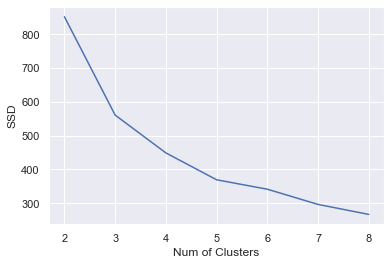

In [572]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(fin_data)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters, ssd)
plt.xlabel('Num of Clusters')
plt.ylabel('SSD')
plt.show()

In [510]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

sil_score = []
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(fin_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(fin_data, cluster_labels)
    sil_score.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.47852916666651724
For n_clusters=3, the silhouette score is 0.4234533288749327
For n_clusters=4, the silhouette score is 0.4095870546916226
For n_clusters=5, the silhouette score is 0.41577510179271215
For n_clusters=6, the silhouette score is 0.3137163593450694
For n_clusters=7, the silhouette score is 0.29686250573935824
For n_clusters=8, the silhouette score is 0.29804232766193395


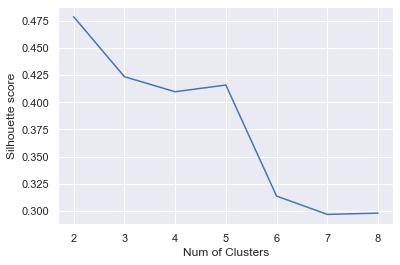

In [573]:
plt.plot(range_n_clusters, sil_score)
plt.xlabel('Num of Clusters')
plt.ylabel('Silhouette score')
plt.show()

**Looking at the Elbow Curve and the Silhouette Score, we take K = 3**

In [532]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50, random_state = 60)
kmeans.fit(fin_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=60, tol=0.0001, verbose=0)

In [533]:
# Assign the labels to the original dataset with the country names
findata['cluster_id'] = kmeans.labels_
findata.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1


* We can see that Afghanistan and Angola have been assigned to cluster 2
* Albania, Algeria and Antigua and Barbuda are in cluster 1

## 8.0 Clustering Analysis

We now plot box plots of the 3 variables we have decided to use for clustering analysis (**`gdpp`**, **`income`** and **`child_mort`**) and see the behaviour of different clusters

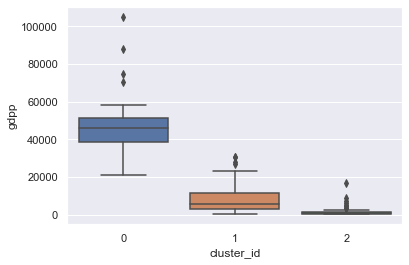

In [534]:
sns.boxplot(x='cluster_id', y='gdpp', data=findata)
plt.show()

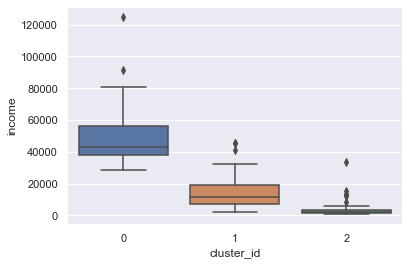

In [535]:
sns.boxplot(x='cluster_id', y='income', data=findata)
plt.show()

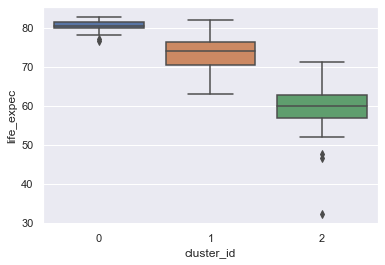

In [536]:
sns.boxplot(x='cluster_id', y='life_expec', data=findata)
plt.show()

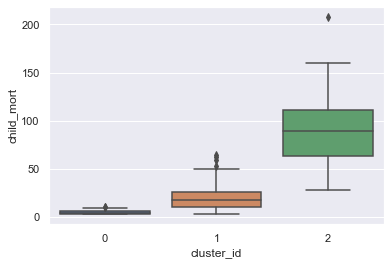

In [537]:
sns.boxplot(x='cluster_id', y='child_mort', data=findata)
plt.show()

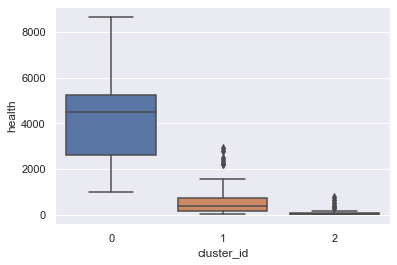

In [538]:
# plot
sns.boxplot(x='cluster_id', y='health', data=findata)
plt.show()

- ### 8.1 Observations

We can observe the following:

1. The countries with lowest gdpp are in Cluster 2
2. If we see the other parameters, we can notice that these countries also have:
   - lowest per-capita income
   - lowest healthcare spend
   - lowest life-expectancy
   - highest child mortality

3. So, these are the countries that appear to be in dire need of aid

  - ### 8.2 Cluster Plots
  
    - We now plot the different clusters and see how clustering shows up, between the 3 parameters we have considered, i.e., `gdpp`, `income` and `child_mort`

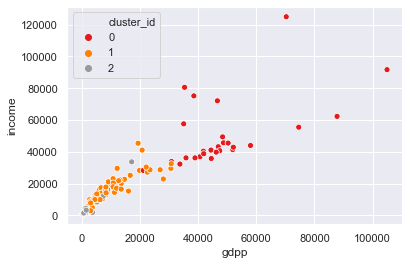

In [364]:
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'cluster_id', data = findata, palette = 'Set1')
plt.show()

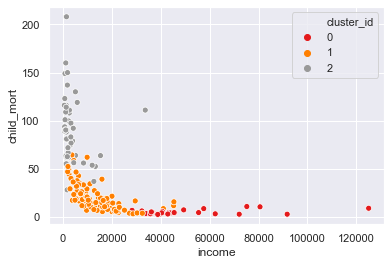

In [365]:
sns.scatterplot(x = 'income', y = 'child_mort', hue = 'cluster_id', data = findata, palette = 'Set1')
plt.show()

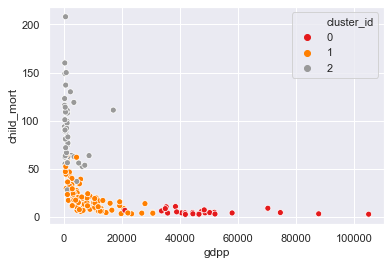

In [366]:
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = 'cluster_id', data = findata, palette = 'Set1')
plt.show()

 - ### 8.3 Observations
 We can observe the following:
  1. The countries with high gdpp and income fall in cluster 0, ones with medium figures fall in cluster 1 and the lowest gdpp countries fall in cluster 2
  2. Countries with high income and very low child-mortality are in cluster 0, ones with medium child_mort, in cluster 1 and those with highest child_more in cluster 2
  3. Similarly, with gdpp as well. This plot shows a behviour exactly similar to the income vs child_mort plot
  
**We can see that all these plots show proper clustering of data, where there is generally very little overlap between points of one cluster and those of another** This means that clustering has been successful in seggregating the countries based on these parameters

## 9.0 Cluster Profiling

Now, we take the average of each of these columns, **based on clusters** and plot bar-plots of these averages for different clusters

In [368]:
findata.drop(['country'], axis = 1).groupby('cluster_id').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,5.092593,31897.859259,4378.955185,26469.600000,50833.333333,3.120407,80.462963,1.775185,48759.259259
1,20.177174,3650.066288,573.165330,3759.545881,14169.456522,6.995435,73.552174,2.225652,8226.869565
2,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333


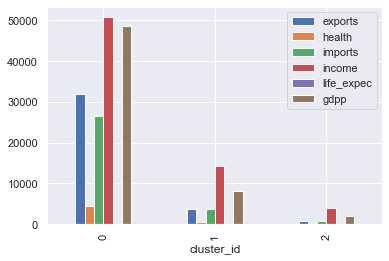

In [369]:
findata.drop(['country', 'child_mort', 'inflation', 'total_fer'], axis = 1).groupby('cluster_id').mean().plot(kind = 'bar')
plt.show()

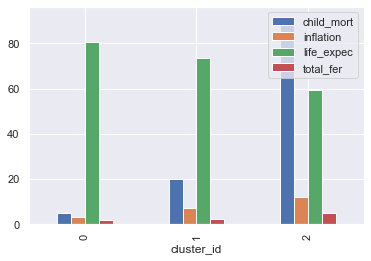

In [370]:
findata.drop(['country', 'exports', 'health', 'imports', 'income', 'gdpp'], axis = 1).groupby('cluster_id').mean().plot(kind = 'bar')
plt.show()

 - ### 9.1 Observations
 
   - We can make observations similar to the ones made when we plotted the box-plots
       - Cluster 2 countries have lowest gdpp, income, healthcare allocation and life-expectancy
       - These countries have highest child mortality and inflation

## 10.0 Final Decision based on K-means clustering

Below, the coutnries in cluster 2 are arranged as below:
1. In ascending order of their **`gdpp`** (gdp per-capita)
2. In ascending order of thier **`income`** (per-capita income)
3. In descending order of their **`child_mort`**

The first 5 countries in these are in dire need of aid and the NGO can make a desicion to give aid to these countries, where the aid can be well-spent for developmental purposes.

Following are the countries:
1. Burundi
2. Liberia
3. Congo, Dem. Rep. (Democratic Republic of Congo)
4. Niger
5. Sierra Leone
6. Haiti            (based on child mortality)
7. Chad             (based on child mortality)
8. Central African Republic    (based on child mortality)

In [371]:
findata[findata.cluster_id == 2].sort_values(by = 'gdpp', ascending = True, axis = 0).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,2
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327,2
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,2
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348,2
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399,2


In [372]:
findata[findata.cluster_id == 2].sort_values(by = 'income', ascending = True, axis = 0).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,2
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327,2
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,2
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348,2
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446,2


In [373]:
findata[findata.cluster_id == 2].sort_values(by = 'child_mort', ascending = False, axis = 0).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,2
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,2
32,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,2
31,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,2
97,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,2


## 11.0 Hierarchical Clustering

We now do Hieararchical clustering on the same dataset

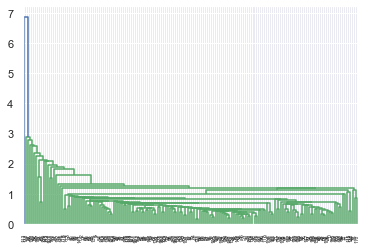

In [374]:
mergings = linkage(fin_data, method = 'single', metric = 'euclidean')
dendrogram(mergings)
plt.show()

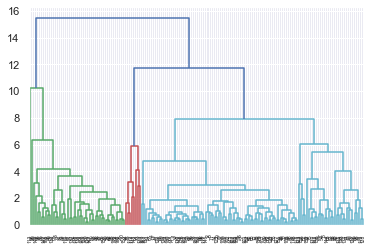

In [375]:
mergings = linkage(fin_data, method = 'complete', metric = 'euclidean')
dendrogram(mergings)
plt.show()

  - ### 11.1 Observations
  
From the above 2 clusting schemes (Single Linkage where the minimum Euclidean Distances are compared and Complete Linkage, here maximum ED are compared and min of that is taken), we can see that clear clusters are formed when **Complete Linkage** is used.

Hence, we decide to use Complete Linkage.

Further, we see that 3 clusters are clearly formed (Green, Red and Cyan).

So, we take **no. of clusters = 3** and cut the tree

In [539]:
# create 3 clusters

cluster_labels = cut_tree(mergings, n_clusters = 3).reshape(-1, )
cluster_labels
print(sum(cluster_labels))
cluster_labels

127


array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [540]:
findata['clusters_hier'] = cluster_labels
findata.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,clusters_hier
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1,1


## 12.0 Hierarchical Clustering Analysis

We now plot box plots, as in the K-means case and analyze the clusters.

Again, box plots are plotted for clusters against:
1. `gdpp`
2. `income`
3. `life_expec`
4. `child_mort`
5. `health`

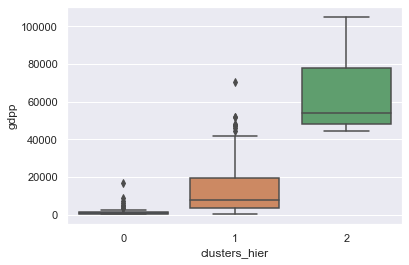

In [541]:
sns.boxplot(x='clusters_hier', y='gdpp', data=findata)
plt.show()

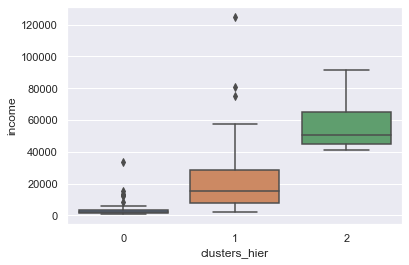

In [542]:
# plot
sns.boxplot(x='clusters_hier', y='income', data=findata)
plt.show()

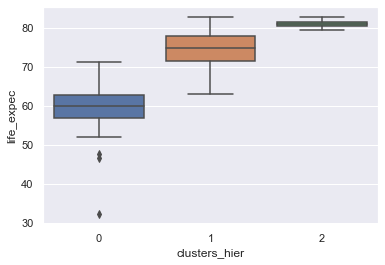

In [543]:
# plot
sns.boxplot(x='clusters_hier', y='life_expec', data=findata)
plt.show()

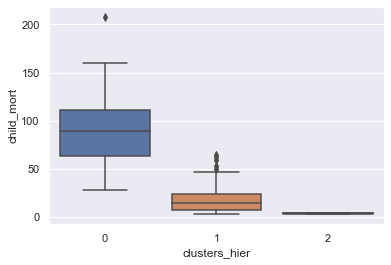

In [544]:
# plot
sns.boxplot(x='clusters_hier', y='child_mort', data=findata)
plt.show()

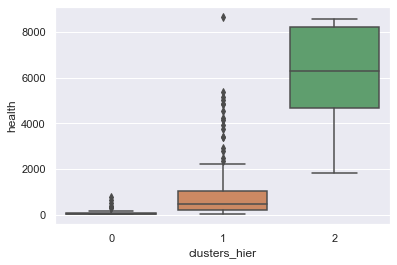

In [545]:
# plot
sns.boxplot(x='clusters_hier', y='health', data=findata)
plt.show()

  - ### 12.1 Observations
  
  We observe the following:
  
  1. Cluster 0 has countries with low gdpp, income, life-expectancy and healthcare allocation
  2. These countries also have very high child-mortality
  3. Cluster 1 has medium metrics for these parameters
  4. Cluster 2 has countries with very high gdpp, income, life-expectancy and healthcare allocation and very low child-mortality
  
  If we compare the countries in cluster 0 here, with the countries in cluster 2 obtained through K-means clustering, they are the same countries



  - ### 12.2 Cluster Plots
  
  We plot below, the scatter plots of `gdpp`, `income` and `child_mort` against each other, with **clusters** as the paramter

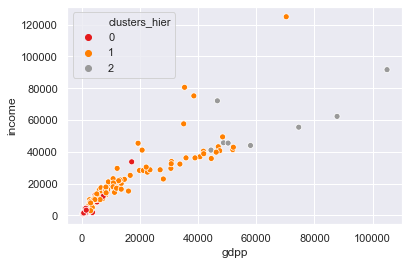

In [546]:
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'clusters_hier', data = findata, palette = 'Set1')
plt.show()

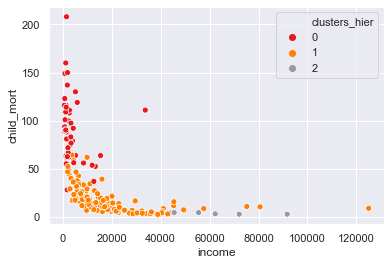

In [547]:
sns.scatterplot(x = 'income', y = 'child_mort', hue = 'clusters_hier', data = findata, palette = 'Set1')
plt.show()

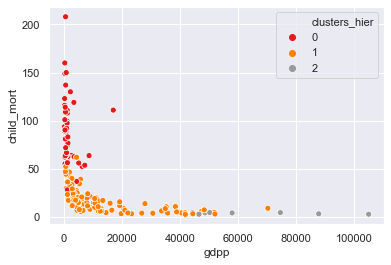

In [548]:
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = 'clusters_hier', data = findata, palette = 'Set1')
plt.show()

  - ## 10.3 Observations
  
  Again, the observations are similar to those in K-means clustering with just the cluster numbers changed.
  
  1. Cluster 0 has countries with high child-mortality and low gdpp and income
  2. Cluster 1 has countries with medium values of these
  3. Cluster 2 has countries with highly acceptable values of these parameters
  4. Further, we can see that even here, there is very little overlap between the clusters
  
**So, using Hierarchical Clustering as well, the clustering has been done very well**

## 13.0 Cluster Profiling

* Here again, we take averages of the different columns and plot bar plots of the same

In [549]:
findata.drop(['country', 'cluster_id'], axis = 1).groupby('clusters_hier').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
clusters_hier,,,,,,,,,
0,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333
1,17.686486,6197.379266,1101.195229,5702.860550,19983.693694,6.443802,74.698198,2.151982,14035.783784
2,3.825000,63642.400000,6091.291250,53442.487500,57237.500000,1.571125,80.975000,1.727500,64425.000000


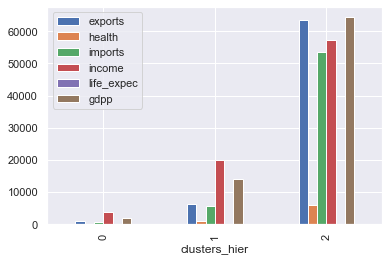

In [550]:
findata.drop(['country', 'cluster_id', 'child_mort', 'inflation', 'total_fer'], axis = 1).groupby('clusters_hier').mean().plot(kind = 'bar')
plt.show()

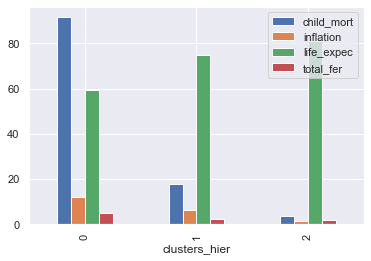

In [551]:
findata.drop(['country', 'cluster_id', 'exports', 'health', 'imports', 'income', 'gdpp'], axis = 1).groupby('clusters_hier').mean().plot(kind = 'bar')
plt.show()

 - ### 13.1 Observations
 
 Again, we observe the following:
 1. Countires in Cluster 0 have very low gdpp, income, life-expectancy and healthcare allocation and high values of child-mortality and inflation
 2. Countries in Cluster 1 have medium values of these
 3. Countries in Cluster 2 have very high values gdpp, income, life-expectancy and health-care allocation and low inflation and child-mortality

## 14.0 Final Decision based on Hierarchical Clustering

Below, the coutnries in cluster 2 are arranged as below:
1. In ascending order of their gdpp (gdp per-capita)
2. In ascending order of thier income (per-capita income)
3. In descending order of their child_mort]

In [562]:
print("Hierarchical Clustering by gdpp")
print('='*32)
findata[findata.clusters_hier == 0].sort_values(by = 'gdpp', ascending = True, axis = 0).head()

Hierarchical Clustering by gdpp


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,clusters_hier
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,2,0
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327,2,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,2,0
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348,2,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399,2,0


In [567]:
print("Hierarchical Clustering by income")
print('='*34)
findata[findata.clusters_hier == 0].sort_values(by = 'income', ascending = True, axis = 0).head()

Hierarchical Clustering by income


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,clusters_hier
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,2,0
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327,2,0
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,2,0
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348,2,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446,2,0


In [571]:
print("Hierarchical Clustering by child_mort")
print('='*38)
findata[findata.clusters_hier == 0].sort_values(by = 'child_mort', ascending = False, axis = 0).head()

Hierarchical Clustering by child_mort


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,clusters_hier
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,2,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,2,0
32,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,2,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,2,0
97,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,2,0


### Decision:

The first 5 countries in this cluster are in dire need of aid and the NGO can make a desicion to give aid to these countries, where the aid can be well-spent for developmental purposes.

Following are the countries:

1. Burundi
2. Liberia
3. Congo, Dem. Rep. (Democratic Republic of Congo)
4. Niger
5. Sierra Leone
6. Haiti (based on child mortality)
7. Chad (based on child mortality)
8. Central African Republic (based on child mortality)
9. Mali (based on child mortality)